In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3

In [21]:
# Define regression problem
[x_min, x_max] = [0, 5]

def true_function(x, a=1, b=1, c=1):
    y = a + b*x + c*x**2
    return y

def linear_model(x, a=1, b=1):
    y = a + b*x
    return y

def generate_observed_data(Nobs, noise_sigma=1):
    x = np.random.uniform(low=x_min, high=x_max, size=[Nobs])
    y = true_function(x) + noise_sigma * np.random.randn(Nobs)
    return (x,y)

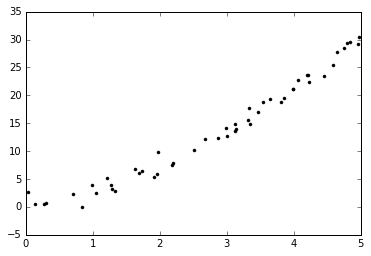

In [3]:
# Generate data
Nobs = 50
(x_obs, y_obs) = generate_observed_data(Nobs)
plt.plot(x_obs, y_obs, 'k.');
y_true = true_function(x_obs) # true (unknown) function values

In [7]:
# Infer linear model
with pymc3.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.) # data noise
    a = pymc3.Normal('a', 0, sd=20) 
    b = pymc3.Normal('b', 0, sd=20) 

    # Define likelihood
    likelihood = pymc3.Normal('y', mu=a + b * x_obs, 
                        sd=sigma, observed=y_obs)

    # Inference
    print('Finding MAP fit...')
    start = pymc3.find_MAP() # Find starting value by optimization
    print('Sampling from posterior...')
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(2000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling



Applied log-transform to sigma and added transformed sigma_log to model.
Finding MAP fit...
Sampling from posterior...


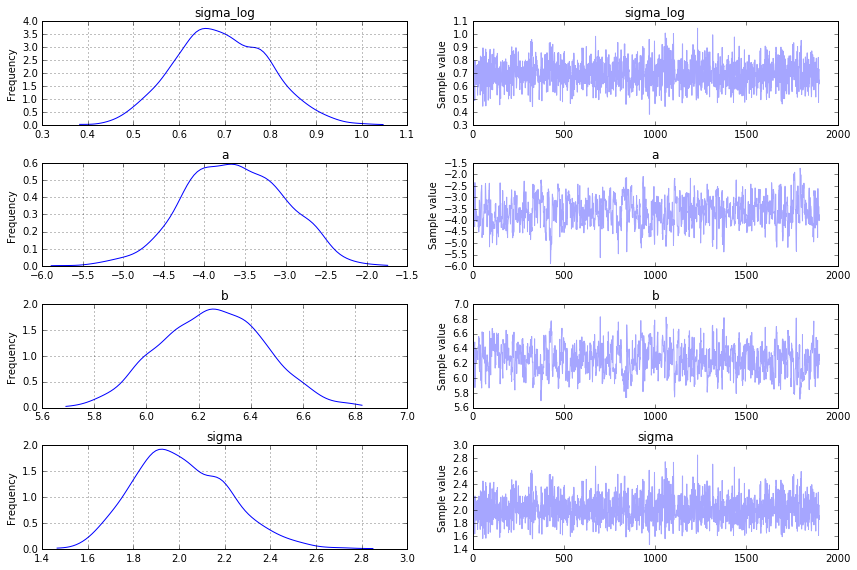

In [8]:
plt.figure(figsize=(7, 7))
pymc3.traceplot(trace[100:])
plt.tight_layout();

TypeError: Invalid arguments to legend.

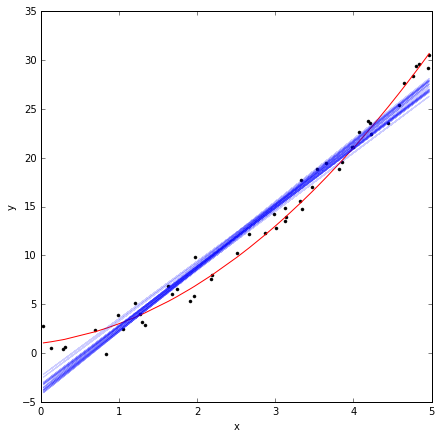

In [43]:
nequil = 100 # number of initial samples to discard
nthin = 100 # thinning for plots

# Let's compare the observed data and models
y_true = true_function(x_obs) # true (unknown) function values
plt.figure(figsize=(7,7));
plt.plot(x_obs, y_obs, 'k.'); # observed data
plt.hold(True);

indices = np.argsort(x_obs)
plt.plot(x_obs[indices], y_true[indices], 'r-'); # true function values

nsamples = len(trace[nequil::nthin])
for index in range(nsamples):
    y_model = linear_model(x_obs, a=trace[nequil:].a[index], b=trace[nequil:].b[index])
    plt.plot(x_obs, y_model, 'b-', alpha=0.2) # models
    
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['observations', 'true function', 'model'])


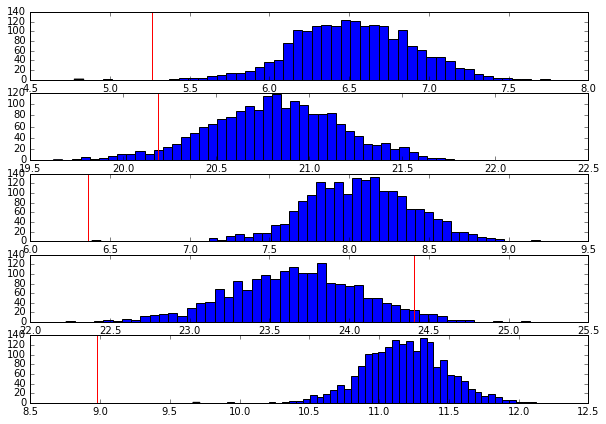

In [29]:
# For each observation, we have a true error and a predicted error.
# Let's plot some examples of new data
# We plot a histogram of the prediction (blue histogram) and the true function (red vertical line)
Nnew = 5
[x_new, y_new] = generate_observed_data(Nnew)
y_true = true_function(x_new)

# What fraction of time is the true error less than the predicted error?
plt.figure(figsize=(10, 7))
confidence_intervals = np.arange(0, 1, 0.05)
nsamples = len(trace[nequil:])
y_predictions = np.zeros([nsamples], )
for i in range(Nnew):
    plt.subplot(Nnew,1,i+1)
    # Plot a histogram of the predictions from the model
    y_predictions = linear_model(x_new[i], a=trace[nequil:].a, b=trace[nequil:].b)
    plt.hist(y_predictions, 50);
    plt.hold(True);
    oldaxis = plt.axis();
    # Plot the true function value
    plt.plot( [y_true[i], y_true[i]], [0, oldaxis[3]], 'r-');

1900